# Electromagnetic cascade example

This is a simple 1D example of gamma-ray propagation over cosmological distances.
Note that only pair production and inverse Compton scattering are relevant for the energy range of this example.
Moreover, the radio background is negligible for the energy range below PeV.


In [3]:
from crpropa import *

dsrc = redshift2ComovingDistance(0.14)

electrons = True
photons = True

thinning = 0.90 # if 0, no thinning; speeds up the simulations considerably

cmb = CMB()
ebl = IRB_Gilmore12()
crb = URB_Nitu21()

sim = ModuleList()
sim.add(SimplePropagation())
sim.add(Redshift())
sim.add(EMPairProduction(cmb, electrons, thinning))
sim.add(EMPairProduction(ebl, electrons, thinning))
# sim.add(EMPairProduction(crb, electrons, thinning)) 
# sim.add(EMDoublePairProduction(cmb, electrons, thinning))
# sim.add(EMDoublePairProduction(ebl, electrons, thinning))
# sim.add(EMDoublePairProduction(crb, electrons, thinning))
sim.add(EMInverseComptonScattering(cmb, photons, thinning))
sim.add(EMInverseComptonScattering(ebl, photons, thinning))
# sim.add(EMInverseComptonScattering(crb, photons, thinning))
# sim.add(EMTripletPairProduction(cmb, electrons, thinning))
# sim.add(EMTripletPairProduction(ebl, electrons, thinning))
# sim.add(EMTripletPairProduction(crb, electrons, thinning))
sim.add(MinimumEnergy(10 * GeV))

obs = Observer()
obs.add(Observer1D())
obs.add(ObserverElectronVeto()) # we are only interested in photons
output = TextOutput('cascade_1d.txt', Output.Event1D)
output.setEnergyScale(eV)
output.enable(output.WeightColumn) # this is required if thinning > 0
output.disable(output.CandidateTagColumn) # not needed in this analysis
obs.onDetection(output)

source = Source()
source.add(SourcePosition(Vector3d(dsrc, 0, 0)))
source.add(SourceRedshift1D())
source.add(SourceParticleType(22))
source.add(SourcePowerLawSpectrum(10 * GeV, 10 * TeV, -1.5)) # intrinsic source spectrum
# source.add(SourceEnergy(20 * TeV)) # a monochromatic intrinsic spectrum

sim.add(obs)
sim.setShowProgress(True)
sim.run(source, 10000, True)

output.close()


crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Thu Feb  2 13:05:25 2023 : [ Finished ] 100%    Needed: 00:03:43  - Finished at Thu Feb  2 13:09:08 2023


## Plotting

We will now plot the spectrum of photons arriving at Earth.
Note that whenever thinning is used, the weight column has to be enabled and the weights must be accounted for in the analysis.

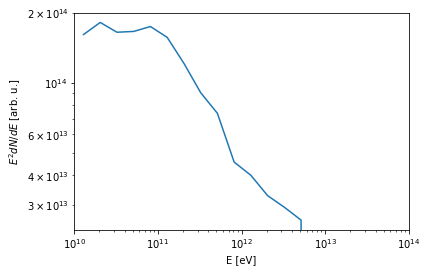

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('cascade_1d.txt', comments = '#')
energy = data[:, 2] # energies in eV
weight = data[:, 5]

bins = np.logspace(10, 15, 26, endpoint = True)
y, edges = np.histogram(energy , bins = bins, weights = weight)
x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
y *= x 
plt.xlim(1e10, 1e14)
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('E [eV]')
plt.show()
